In [ ]:
# Part 0 - SAM example - full image automatic masks detection
import  numpy as np
import  cv2
import  matplotlib.pyplot as plt
from    segment_anything import sam_model_registry, SamAutomaticMaskGenerator

MODEL_PATH = r"C:\Users\Hoan\Desktop\School\Semester_2\CIS_671\Project_2\back-end\SAM_models\sam_vit_b_01ec64.pth"
IMAGE_PATH = r"C:\Users\Hoan\Desktop\School\Semester_2\CIS_671\Project_2\back-end\Images\Original_Img.jpg"

# Load SAM Model - using the ViT-B SAM model 
DEVICE = "cpu" 
sam    = sam_model_registry["vit_b"](checkpoint=MODEL_PATH).to(DEVICE)

# Create an automatic mask generator 
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side         = 16,  
    pred_iou_thresh         = 0.85, 
    stability_score_thresh  = 0.9,
    min_mask_region_area    = 1000
)

# Load and prepare an image - BGR to RGB
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Generate masks
masks = mask_generator.generate(image)

In [3]:
def save_anns(image, anns, output_path="overlay_image.png"):
    if len(anns) == 0:
        print("No annotations to save.")
        return

    # Sort annotations by area (largest first)
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)

    # Create an RGBA image for overlay (same size as original)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], 
                   sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0  # Set full transparency initially

    # Apply sorted masks with random colors
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])  # RGBA color (semi-transparent)
        img[m] = color_mask  # Apply color to mask area

    # Convert mask overlay to 3-channel BGR image for OpenCV
    mask_overlay = (img[:, :, :3] * 255).astype(np.uint8)  # RGB mask
    alpha_mask = img[:, :, 3]  # Alpha channel for transparency

    # Blend only where the mask is present
    for c in range(3):  # Apply alpha blending per channel (R, G, B)
        image[:, :, c] = (1 - alpha_mask) * image[:, :, c] + alpha_mask * mask_overlay[:, :, c]

    # Save the image
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving
    print(f"Saved overlay image to {output_path}")

save_anns(image, masks, r"C:\Users\Hoan\Desktop\School\Semester_2\CIS_671\Project_2\back-end\Images\SAM_Img.jpg")

Saved overlay image to C:\Users\Hoan\Desktop\School\Semester_2\CIS_671\Project_2\back-end\Images\SAM_Img.jpg


In [ ]:
# Mask data
print("Total masks: ", len(masks))
print(masks[0].keys())

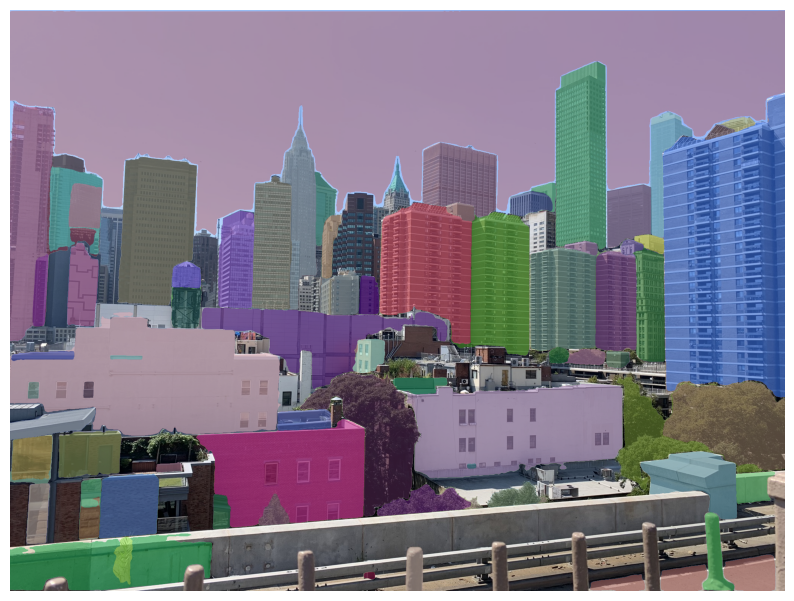

In [33]:
# Visualize segmentation results
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax          = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m           = ann['segmentation']
        color_mask  = np.concatenate([np.random.random(3), [0.35]])
        img[m]      = color_mask
    ax.imshow(img)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
plt.axis("off")
plt.show()